In [1]:
import sys
import os

In [11]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
import time
sys.path.insert(1, '../utils')
from utils import *
from utils import plot_solution, greedy_2_regret_weighted, score
from typing import Callable, Any
from abc import ABC, abstractmethod
from sortedcontainers import SortedList

In [ ]:
from sys import maxsize
from typing import SupportsIndex


class CustomList(list):
    def __init__(self, *args):
        super().__init__(*args)  # Unpack *args here
        self.indexes = dict()
        for i, e in enumerate(self):
            self.indexes[e] = i
        self.ordered_list = list(range(len(self)))

    def index(self, value: Any, start: SupportsIndex = 0, stop: SupportsIndex = sys.maxsize) -> int:
        return self.indexes[value]
    
    def __setitem__(self, index, value):
        if type(index) == slice:
            print(self.ordered_list)
        print(index)
        print(value)
        del self.indexes[self[index]]
        super().__setitem__(index, value)
        self.indexes[value] = index
        


l = CustomList([9, 4, 7])
# l[:2] = [3,2]
l.ordered_list

    

[0, 1, 2]

In [3]:
a=pd.read_csv('../data/TSPA.csv', sep=';', header=None)
b=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])
tspb=pd.DataFrame(data=b.values, columns=['x', 'y', 'val'])
coordinates=tspa[['x', 'y']].values
coordinatesb=tspb[['x', 'y']].values
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
distb=distance_matrix(coordinatesb, coordinatesb)
distb=np.round(distb)
costs=tspa[['val']].values
costsb=tspb[['val']].values

In [4]:
def get_random_solution(n: int) -> list[int]:
    a=np.arange(0,n)
    np.random.shuffle(a)

    return list(a[:int(np.ceil(n/2))])

In [5]:
class Neighborhood(ABC):
    @abstractmethod
    def neighborhood_size(self):
        pass

    @abstractmethod
    def get_difference(self, ind, solution: List[int], unselected):
        pass

    @abstractmethod
    def modify_solution(self, ind, solution: List[int], unselected):
        pass


In [6]:
a = [1, 3, 5]
a.index(3)

1

In [7]:
class EdgeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.indexes = list()
        for i in range(1, n-1):
            m = n - 1 if i == 1 else n
            for j in range(i+1, m):
                self.indexes.append((i,j))

    def get_difference_nodes(self, node1: int, node2: int, solution: List[int], unselected: SortedList):
        i  = solution.index(node1)
        j = solution.index(node2)
        i, j = min((i,j)), max((i,j))

        rotated_solution = solution.copy()
        rotated_solution = rotated_solution[i:] + rotated_solution[:i]
        j = j - i

        n = len(rotated_solution)
        
        return self.get_difference_ij(1, j, rotated_solution, unselected), self.get_difference_ij(j, n-1, rotated_solution, unselected)
    
    def modify_solution_nodes(self, node1: int, node2: int, solution: List[int], unselected: SortedList, ind: int):
        i  = solution.index(node1)
        j = solution.index(node2)
        i, j = min((i,j)), max((i,j))

        rotated_solution = solution.copy()
        rotated_solution = rotated_solution[i:] + rotated_solution[:i]
        if ind == 0:
            rotated_solution[1:j-i+1] = rotated_solution[j-i:0:-1]
        else:
            rotated_solution[j-i:] = rotated_solution[:j-i-1:-1]

        return rotated_solution

    def get_difference_ij(self, i:int, j:int, solution: List[int], unselected: SortedList):
        n = len(solution)
        i1 = solution[i - 1]
        i2 = solution[i]

        j1 = solution[j]
        j2 = solution[(j + 1)%n]

        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]

        return self.get_difference_ij(i, j, solution, unselected)
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i:j+1] = solution[j:i-1:-1]
        return solution


In [8]:
from typing import List
#exchange with the neighbor

class InterNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        m = len(self.dist_mat) - n
        for i in range(n):
            for j in range(m):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)

    def get_difference_nodes(self, node1: int, node2: int, solution: List[int], unselected: SortedList):
        n = len(solution)
        i  = solution.index(node1)
        j = unselected.index(node2)

        i1 = (i-1)%n
        i3 = (i+1)%n

        return self.get_difference_ij(i1, j, solution, unselected), self.get_difference_ij(i3, j, solution, unselected)

    def modify_solution_nodes(self, node1: int, node2: int, solution: List[int], unselected: SortedList, ind: int):
        i  = solution.index(node1)
        n = len(solution)
        if ind == 0:
            i = (i-1)%n
        else:
            i = (i+1)%n
        j = node2

        current_node = solution[i]
        solution[i] = j
        unselected.remove(j)
        unselected.add(current_node)
        return solution

    def get_difference_ij(self, i:int, j:int, solution: List[int], unselected: SortedList):
        n = len(solution)
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = unselected[j]

        return -self.dist_mat[i1, i2] -self.dist_mat[i2, i3] + self.dist_mat[i1, j1] + self.dist_mat[j1, i3]

    def get_difference(self, ind, solution: List[int], unselected):
        i, j = self.indexes[ind]
        
        return self.get_difference_ij(i, j, solution, unselected)
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        current_node = solution[i]
        solution[i] = unselected[j]
        unselected.remove(unselected[j])
        unselected.add(current_node)
        return solution

In [9]:
# dist_t = np.array([
#     [0, 1, 10, 0, 0, 6],
#     [1, 0, 2, 7, 0, 0],
#     [10, 2, 0, 3, 8, 0],
#     [0, 7, 3, 0, 4, 0],
#     [0, 0, 8, 4, 0, 5],
#     [6, 0, 0, 0, 5, 0],
# ])
dist_t = np.random.randint(0, 20, (10, 10))
for i in range(10):
    for j in range(10):
        if i == j:
            dist_t[i][j] = 0
        else:
            dist_t[i][j] = dist_t[j][i]
print(dist_t)
cost_t = np.zeros(10)

[[ 0  9 12  1 15  9  3 18 17  4]
 [ 9  0 16 17  7 10 10  8 18 19]
 [12 16  0 14  6 14  2  0 17  9]
 [ 1 17 14  0 17  5 13 12  2  5]
 [15  7  6 17  0 11  5  9  9 14]
 [ 9 10 14  5 11  0  9 12  7 13]
 [ 3 10  2 13  5  9  0  5  4  4]
 [18  8  0 12  9 12  5  0 16  6]
 [17 18 17  2  9  7  4 16  0  5]
 [ 4 19  9  5 14 13  4  6  5  0]]


In [10]:
neighborhood = EdgeNeighborhood(dist_t, cost_t, 5)
neighborhood1 = InterNeighborhood(dist_t, cost_t, 5)
solution_t = get_random_solution(10)
unselected_t = SortedList(range(10))
for i in range(10):
    if i in solution_t:
        unselected_t.remove(i)
print(solution_t)
print(unselected_t)
score(solution_t, dist_t, cost_t)

[6, 1, 0, 3, 7]
SortedList([2, 4, 5, 8, 9])


37

In [11]:
score_i = score(solution_t, dist_t, cost_t)

In [12]:
for i in solution_t:
    for j in solution_t:
        if i != j:
            changes = neighborhood.get_difference_nodes(i,j, solution_t, None)
            s1 = neighborhood.modify_solution_nodes(i,j,solution_t,None,0)
            s2 = neighborhood.modify_solution_nodes(i,j,solution_t,None,1)
            score1 = score_i-score(s1, dist_t, cost_t)
            score2 = score_i-score(s2, dist_t, cost_t)
            assert(changes == (-score1, -score2))

In [13]:
for i in solution_t:
    for j in unselected_t:
        solution_t_c1, unselected_t_c1 = solution_t.copy(), unselected_t.copy()
        solution_t_c2, unselected_t_c2 = solution_t.copy(), unselected_t.copy()
        changes = neighborhood1.get_difference_nodes(i, j, solution_t_c1, unselected_t_c1)
        s1 = neighborhood1.modify_solution_nodes(i,j,solution_t_c1,unselected_t_c1,0)
        s2 = neighborhood1.modify_solution_nodes(i,j,solution_t_c2,unselected_t_c2,1)
        score1 = score_i-score(s1, dist_t, cost_t)
        score2 = score_i-score(s2, dist_t, cost_t)
        assert(changes == (-score1, -score2))

In [14]:
def get_closest_n(distance_matrix: np.ndarray, costs: np.ndarray, n):
    dist_mat = (distance_matrix+costs).T
    result = np.argsort(dist_mat, axis=1)
    for i in range(result.shape[0]):
        shift = False
        for j in range(result.shape[1]-1):
            if result[i][j] == i:
                shift = True
            if shift:
                result[i][j] = result[i][j+1]
    
    return result[:, :n]


In [15]:
a  = np.random.randint(0, 10, (5, 5))
c = np.random.randint(0, 5, (5,1))
for i in range(5):
    for j in range(5):
        if i == j:
            a[i][j] = 0
        else:
            a[i][j] = a[j][i]
print(a)
print(c)
print((a+c).T)

[[0 5 4 9 9]
 [5 0 1 7 3]
 [4 1 0 8 6]
 [9 7 8 0 9]
 [9 3 6 9 0]]
[[0]
 [1]
 [0]
 [4]
 [0]]
[[ 0  6  4 13  9]
 [ 5  1  1 11  3]
 [ 4  2  0 12  6]
 [ 9  8  8  4  9]
 [ 9  4  6 13  0]]


In [16]:
get_closest_n(a,c,4)

array([[2, 1, 4, 3],
       [2, 4, 0, 3],
       [1, 0, 4, 3],
       [1, 2, 0, 4],
       [1, 2, 0, 3]], dtype=int64)

In [26]:
def steepest(
        starting_solution: List[int],
        distance_matrix: np.ndarray,
        costs: np.ndarray,
        edgeNeighborhood: EdgeNeighborhood,
        interNeighborhood: InterNeighborhood
        ) -> list:
    unselected = SortedList(range(len(costs)))
    for i in starting_solution:
        unselected.remove(i)
    
    nearest_neighbors = get_closest_n(distance_matrix, costs, 11)
    solution = starting_solution.copy()
    while True:
        best_objective_change = 0
        best_change = None
        for i in solution:
            for neighbor in nearest_neighbors[i]:
                if neighbor in unselected:
                    used_neighborhood = interNeighborhood
                else:
                    used_neighborhood = edgeNeighborhood
                differences = used_neighborhood.get_difference_nodes(i, neighbor, solution, unselected)
                min_difference = min(differences)
                if min_difference < best_objective_change:
                    best_objective_change = min_difference
                    best_change = (i, neighbor, np.argmin(differences), used_neighborhood)
        if not best_change:
            return solution
        solution = best_change[3].modify_solution_nodes(best_change[0], best_change[1], solution, unselected, best_change[2])
            


In [27]:
initial_solution = get_random_solution(200)


In [28]:
edgeNeighborhood = EdgeNeighborhood(dist, costs, 100)
interNeighborhood = InterNeighborhood(dist, costs, 100)
solution = steepest(initial_solution, dist, costs, edgeNeighborhood, interNeighborhood)

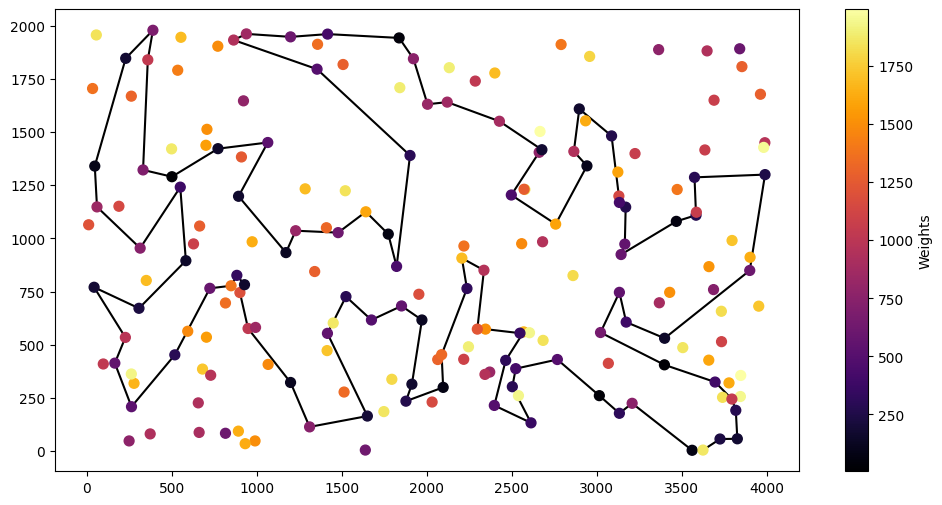

In [30]:
plot_solution(solution, coordinates, costs, '')

In [31]:
def test_method(edgeNeighborhood: EdgeNeighborhood, interNeighborhood: InterNeighborhood, initial_solutions: list, dist, costs, coordinates, name='',):
    scores_2=[]
    sols_2=[]
    times = list()
    for x in range(200):
        initial_solution = initial_solutions[x].copy()
    
        begin_time = time.time()
        solution_2=steepest(initial_solution, dist, costs, edgeNeighborhood, interNeighborhood)
        times.append(time.time() - begin_time)

        solution_2 = [int(e) for e in solution_2]
        sols_2.append(solution_2)

        scores_2.append(score(solution_2, dist, costs))   

    print('scores of greedy, random, node neighborhood: ', min(scores_2), sum(scores_2)/len(scores_2), max(scores_2))
    print(sols_2[scores_2.index(min(scores_2))])
    print(f'execution time: {min(times)} {sum(times)/len(times)} {max(times)}')
    plot_solution(sols_2[scores_2.index(min(scores_2))], coordinates, costs, f'best solution for {name}')

In [33]:
random_solutions = [get_random_solution(200) for _ in range(200)]

scores of greedy, random, node neighborhood:  72656 76679.07 81469
[22, 146, 181, 34, 54, 177, 10, 190, 84, 4, 112, 123, 127, 70, 135, 154, 180, 53, 136, 63, 94, 189, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 129, 92, 57, 55, 179, 145, 78, 16, 171, 175, 113, 56, 31, 196, 81, 90, 165, 40, 185, 52, 106, 178, 49, 14, 144, 62, 9, 148, 186, 23, 89, 183, 137, 176, 80, 79, 133, 151, 162, 149, 131, 35, 184, 48, 160, 42, 43, 116, 65, 59, 118, 115, 41, 139, 46, 0, 153, 143, 117, 93, 140, 68, 108, 69, 18, 199, 193, 159]
execution time: 2.6417481899261475 3.1927006995677947 5.5738160610198975


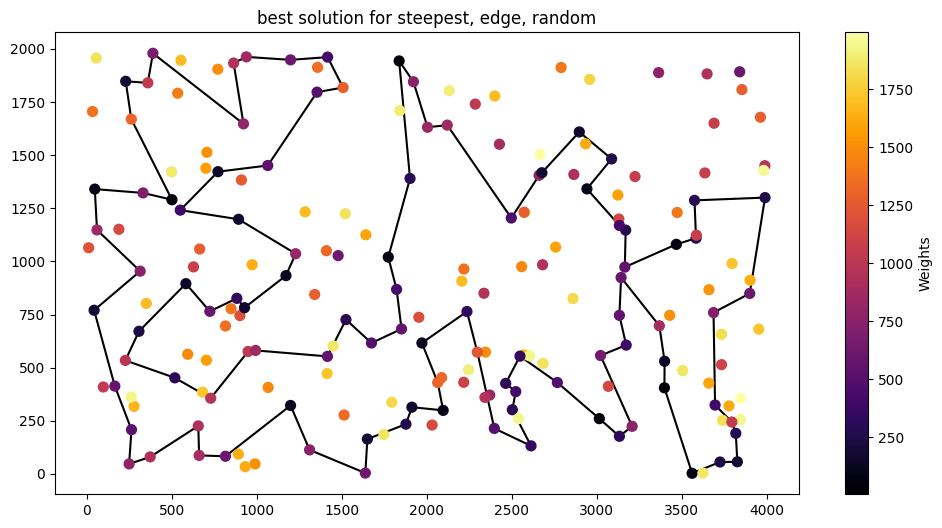

In [35]:
test_method(edgeNeighborhood, interNeighborhood, random_solutions, dist, costs, coordinates, 'steepest, edge, random')

In [44]:
n = 200
interNeighborhood = InterNeighborhood(dist, costs, n // 2)
edgeNeighborhood = EdgeNeighborhood(dist, costs, n // 2)


In [46]:
n = 200
interNeighborhoodb = InterNeighborhood(distb, costsb, n // 2)
edgeNeighborhoodb = EdgeNeighborhood(distb, costsb, n // 2)
neighborhood2b = CombinedNeighborhood([edgeNeighborhoodb, interNeighborhoodb])

In [ ]:
test_method(steepest, neighborhood2b, random_solutions,distb, costsb, coordinatesb, 'steepest, edge, random')